Corpora:

- corpus Gysseling (makkelijk, het lidwoord-zijn zit in subtype bij pronoun/determiner)
- brievenalsbuit (17e en 18e eeuw graag even apart houden, dus twee tellingen per eeuw om te zien of er een verandering zit)  (hier is geen onderscheid bepaald/onbepaald gecodeerd, maar dat is natuurlijk uit het lemma te halen; hier zou je ook iets met sociale status etc kunnen proberen)
- CLVN (misschien even strikt beperken tot 15e en 16e eeuw) (is niet betrouwbaar taalkundig verrijkt, dus lastig)
- Corpus hedendaags Nederlands (makkelijk)
- CGN (makkelijk)
- SoNar (makkelijk) (groeperen naar textsoort?)
- Wablief (iets lastiger, heb ik niet paraat ergens staan)
- zeventiende eeuwse kranten  (lastig, is niet taalkundig verrijkt)
- het corpus tijdschriften van Freek Van de Velde voor de 19e en 20e eeuw [zal ik dat aan Freek vragen?] (hebben we wel in huis, dus kunnen wij ook doen)
- twitter via Gosse (kan Gosse dat doen?)


In [1]:
from chaininglib.ui.search import create_corpus_ui
from chaininglib.ui.dfui import display_df
from chaininglib.search.CorpusQuery import *
import chaininglib.constants as constants
from chaininglib.constants import add_corpus
import re
import random
from IPython.core.display import HTML

#def add_corpus(name, config):
#  constants.AVAILABLE_CORPORA[name] = config

add_corpus('ja_nl', {'blacklab_url':'http://corpora.ato.ivdnt.org/blacklab-server//JapansNederlands',
                     'default_method':'blacklab'})
add_corpus('chn_i', {'blacklab_url':'http://svotmc10.ivdnt.loc/blacklab-server/chn-intern',
                     'default_method':'blacklab'})
add_corpus('zeebrieven_i', {'blacklab_url':'http://svotmc10.ivdnt.loc/blacklab-server/zeebrieven',
                     'default_method':'blacklab'})
add_corpus('gysseling', {'blacklab_url':'http://corpusgysseling.ivdnt.org/blacklab-server/Gysseling',
                     'default_method':'blacklab'})
add_corpus('wablieft', {'blacklab_url':'http://pcob67:8080/blacklab-server/Wablieft',
                     'default_method':'blacklab'})
add_corpus('opensonar', {'blacklab_url':'http://svotmc10.ivdnt.loc/blacklab-server/opensonar',
                     'default_method':'blacklab'})



corpus_name='zeebrieven'

def opensonar_lemma_query(lemma):
    corpus_searched = create_corpus('wablieft')
    df_lemma = corpus_searched.pattern("[lemma='" + lemma + "]").search().kwic()
    df_lemma.to_csv("/tmp/" + lemma + ".csv")
    display_df(df_lemma)



def test_zeebrieven():
  corpus_name='zeebrieven_i'
  corpus_searched = create_corpus(corpus_name).pattern("[lemma='kapitein']").group_by(["hit:word:i"]).max_results(1000).search()
  df_corpus = corpus_searched.kwic()
  display_df(df_corpus)
  print(corpus_searched.summary())

def test_ja_nl():
  corpus_name='ja_nl'
  query='([pos="Verb.*" & lemma != "する"]|[pos="Noun.*"][lemma="する"]) within (<sentence/> (<s/> containing [lemma="vernietigen"]))'
  # corpus_searched = create_corpus(corpus_name).pattern(query).group_by(["field:genre:i"]).max_results(1000).search()
  corpus_searched = create_corpus(corpus_name).pattern(query).group_by(["field:genre:i"]).max_results(0).search()
  df_corpus = corpus_searched.kwic()
  summary = corpus_searched.summary()
  print(summary)
  print(df_corpus.to_string())
  print(summary)

def wordQuery(w):
    z=  " ".join(map(lambda x: '[word="' + x + '"]', w.split(' ')))
    print(z)
    return z

def test_cgn():
  query="[lemma='de']"
  cgn_filter={'Corpus_title': 'CGN'}
  cgn_corpus = create_corpus('opensonar').metadata_filter(cgn_filter)
  cgn_searched = cgn_corpus.pattern(query).group_by(["field:Age:i"]).search()
  df=cgn_searched.kwic()
  display_df(df)
  print(cgn_searched.summary())
  plot_df(df, 'identityDisplay', y_columns=['hits_per_million'] )
  
def test_openchn(query):
  corpus = create_corpus('openchn')
  #query = "[lemma='de']"
  grouping = ['field:witnessYear_from:i']
  df = corpus.pattern(query).group_by(grouping).max_results(1000000000).search().kwic()
  display_df(df)
  plot_df(df,'identityDisplay', ['hits_per_million'])
  return df

def search_and_group(corpus_name,query, field, filter=None, validity_filter="^[0-9]{4}$"):
  corpus = create_corpus(corpus_name)
  if not filter == None:
    corpus=corpus.metadata_filter(filter)
  
  grouping = ['field:' + field + ':i']
  df = corpus.pattern(query).group_by(grouping).max_results(1000000000).search().kwic()
  
  if not validity_filter == None: # remove some data noise (non-wellformed dates etc)
     df = df[df.apply(lambda x:  re.match(validity_filter, x['identityDisplay']) != None, axis=1)]
  return df

# disable caching for query by adding a random clause 
def disguise(query):
  return query.replace("]", " | lemma='gna_gna_" + str(random.randint(0,1000000)) +  "']")

# simulate grouping by separate querying for each value
def silly_grouping(corpus_name, query, field, values, validity_filter="^[0-9]{4}$"):
    result_frames = list(map(
        lambda value:
        search_and_group(corpus_name,
                                       disguise(query),
                                       field, filter={field: value},
                                       validity_filter=validity_filter),
        values))
    concatenation =  pd.concat(result_frames)
    #display_df(concatenation)
    #plot_df(concatenation, 'identityDisplay', 'hits_per_million')
    return concatenation

def flatten(l):
    return [item for sublist in l for item in sublist]

def merge_frames(frames, key_field, display_field):
    merged_frame = frames[0].rename(columns={display_field: display_field + '_0'})
    for i in range(1,len(frames)):
        #print('merging:' + str(i))
        renamed_frame=frames[i].rename(columns={display_field: display_field + '_' + str(i)})
        merged_frame = pd.merge(merged_frame,renamed_frame,on=key_field,how='outer')
    return merged_frame

def search_and_group_multiple(corpus_name, queries, grouping_field, filter=None, validity_filter="^[0-9]{4}$", values=None):
  if values:
      dataframes = list(map(lambda q: silly_grouping(corpus_name, q, grouping_field, values, validity_filter), queries))
  else:
      dataframes = list(map(lambda q: search_and_group(corpus_name, q, grouping_field, filter, validity_filter), queries))

  #join the frames
  field_to_show = 'hits_per_million'
  merged = merge_frames(dataframes,'identityDisplay', field_to_show)
  
  rename_columns = {}
  for i in range(0,len(queries)):
    rename_columns[field_to_show + '_' + str(i)] = queries[i]
  renamed_frame = merged.rename(columns=rename_columns)
  
  display_df(renamed_frame)
  plot_df(renamed_frame, 'identityDisplay', y_columns=queries)
  return renamed_frame

def frequency_info(corpus_name, query):
    corpus = create_corpus(corpus_name)
    info = corpus.corpus_info()

    try:
        searched_corpus = corpus.max_results(10).pattern(query).search()
        df = searched_corpus.kwic()
        summary = searched_corpus.summary()
        rf = 1000000 * (summary['numberOfHits'] / info['tokenCount'])
        summary['hits_per_million'] = rf
        return summary
    except:
        summary = {'hits_per_million': -1, 'numberOfHits': -1 }
        return summary


    #print("info:" + str(info))
    #print("summary:" + str(summary))

def relative_frequency(corpus_name, query):
    corpus = create_corpus(corpus_name)
    info = corpus.corpus_info()

    searched_corpus = corpus.max_results(10).pattern(query).search()
    df = searched_corpus.kwic()
    # display_df(df)
    summary = searched_corpus.summary()


    rf = 1000000 * (summary['numberOfHits'] / info['tokenCount'])
    summary['hits_per_million'] = rf
    #print("info:" + str(info))
    #print("summary:" + str(summary))
    return rf
    #display_df(df)
    #summary = searched.summary()


def plot_df(df,x_column, y_columns):
    #df_values = df[y_column].apply(lambda x: int(x))
    dfsorted = df.sort_values(by=[x_column])
    dfsorted.plot.line(x_column, y_columns, figsize=[30,15])
    
#test_ja_nl()
def relative(corpus_name, query1, query2):
    rf_de = relative_frequency(corpus_name, query1)
    rf_noun = relative_frequency(corpus_name, query2)
    print(corpus_name + ": " + " de:"  + str(rf_de) + ", noun:" + str(rf_noun))
    print(corpus_name + ": " + str(rf_de / rf_noun))

def sonar_test():
    relative('opensonar', "[lemma='de']", "[pos='N.*soort.*']")

def wablieft_test():
    relative('wablieft', "[lemma='de']", "[pos='NOU-C.*']")

def chn_test():
    relative('chn_i', "[lemma='de']", "[pos='NOU-C.*']")

In [3]:
wablieft_test()
chn_test()
sonar_test()


REQUEST URL:http://pcob67:8080/blacklab-server/Wablieft/hits?&number=10&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%5D&filter=
                                                                 REQUEST URL:http://pcob67:8080/blacklab-server/Wablieft/hits?&number=10&maxcount=-1&waitfortotal=yes&first=0&patt=%5Bpos%3D%27NOU-C.%2A%27%5D&filter=
wablieft:  de:60728.62574105652, noun:213187.77743616523         
wablieft: 0.2848597910789725
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn/hits?&number=10&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%5D&filter=
                                                                 REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn/hits?&number=10&maxcount=-1&waitfortotal=yes&first=0&patt=%5Bpos%3D%27NOU-C.%2A%27%5D&filter=
chn_i:  de:61726.21046138488, noun:206508.70605097333            
chn_i: 0.2989036716260706


In [2]:
test_ja_nl()



REQUEST URL:http://corpora.ato.ivdnt.org/blacklab-server//JapansNederlands/hits?&number=0&maxcount=-1&waitfortotal=yes&first=0&patt=%28%5Bpos%3D%22Verb.%2A%22%20%26%20lemma%20%21%3D%20%22%E3%81%99%E3%82%8B%22%5D%7C%5Bpos%3D%22Noun.%2A%22%5D%5Blemma%3D%22%E3%81%99%E3%82%8B%22%5D%29%20within%20%28%3Csentence/%3E%20%28%3Cs/%3E%20containing%20%5Blemma%3D%22vernietigen%22%5D%29%29&filter=&group=field%3Agenre%3Ai
{'windowHasNext': 'true', 'subcorpusDocs': 2439, 'subcorpusTokens': 14392455, 'numberOfHits': 1725, 'numberOfDocs': 534}
Empty DataFrame
Columns: [identity, identityDisplay, size, docs, subcorpus_docs, subcorpus_tokens, hits_per_million]
Index: []
{'windowHasNext': 'true', 'subcorpusDocs': 2439, 'subcorpusTokens': 14392455, 'numberOfHits': 1725, 'numberOfDocs': 534}


In [16]:
values = [str(j) for j in range(1995,2018)]
#silly_grouping('chn_i', "[lemma='de']",'pubYear_from', values)
search_and_group_multiple('chn_i', ["[lemma='de']", "[pos='NOU-C.*']"], 'pubYear_from', values=values)

REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%20%7C%20lemma%3D%27gna_gna_579183%27%5D&filter=pubYear_from%3A%221995%22&group=field%3ApubYear_from%3Ai
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%20%7C%20lemma%3D%27gna_gna_978282%27%5D&filter=pubYear_from%3A%221996%22&group=field%3ApubYear_from%3Ai
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%20%7C%20lemma%3D%27gna_gna_927037%27%5D&filter=pubYear_from%3A%221997%22&group=field%3ApubYear_from%3Ai
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%20%7C%20lemma%3D%27gna_gna_104422%27%5D&filter=pubYear_from%3A%221998%22&group=field%3ApubYear_from%3Ai
REQUEST URL:http://svotmc10.ivdn

ValueError: An error occured when searching corpus chn_i: 'NoneType' object has no attribute 'find'

,identity,identityDisplay,size,docs,subcorpus_docs,subcorpus_tokens,hits_per_million
0,str:1995,1995,1410,738,129700,69682168,20.234732
0,str:1996,1996,508,220,5926,17130999,29.653846
0,str:1997,1997,153,87,11474,9214430,16.604391
0,str:1998,1998,56,35,2622,3517541,15.920212
0,str:1999,1999,1717,1132,176376,72271680,23.757577


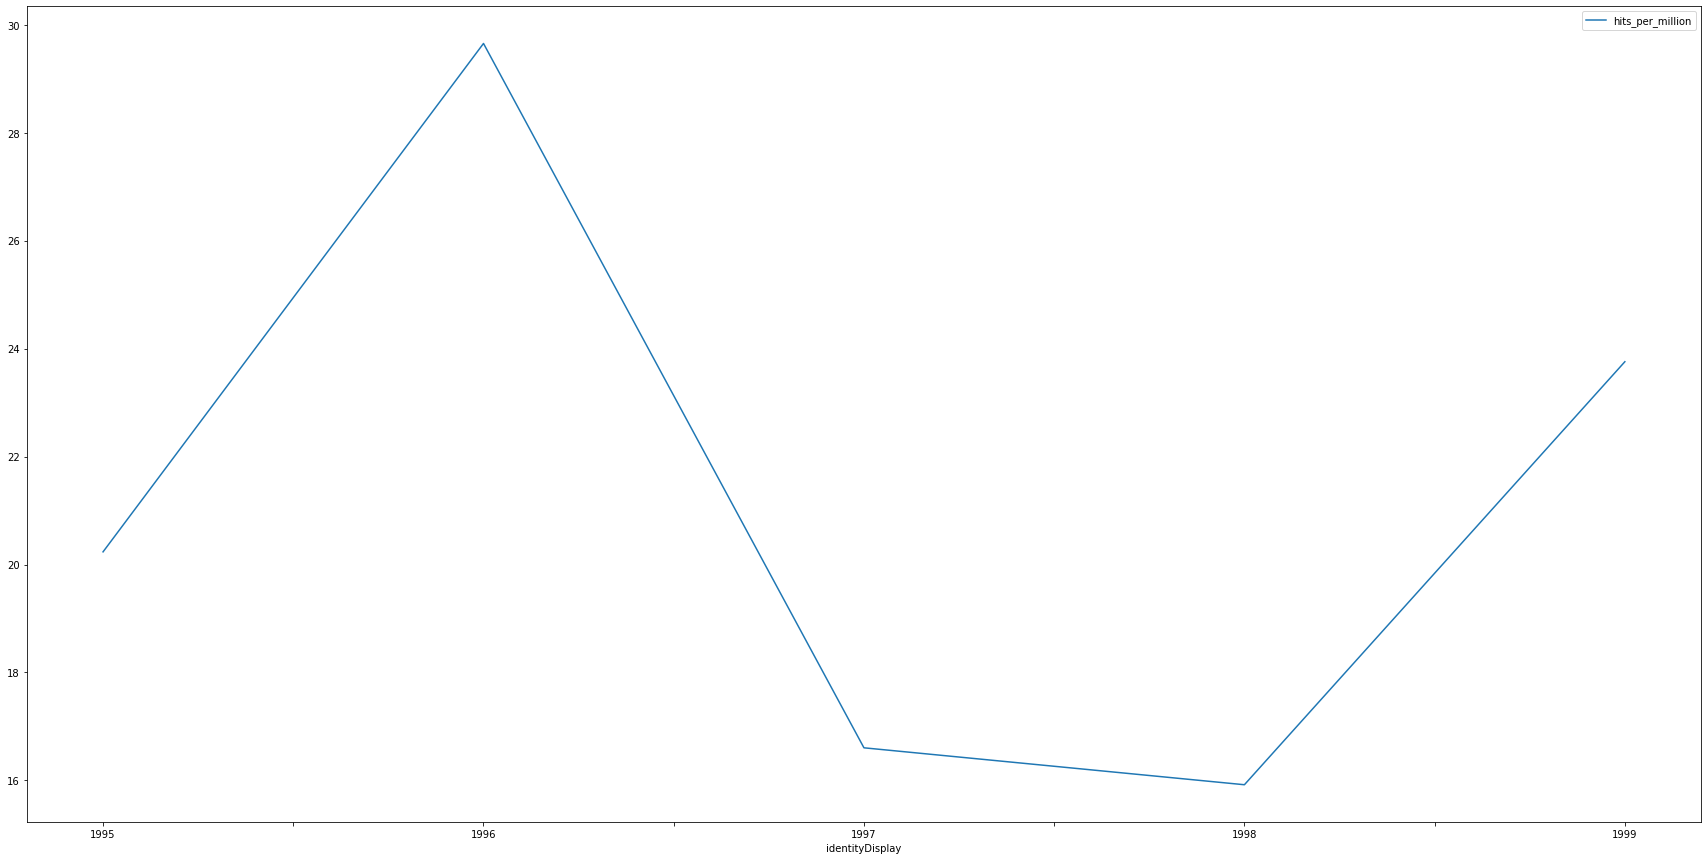

REQUEST URL:http://corpusgysseling.ivdnt.org/blacklab-server/Gysseling/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%20%7C%20lemma%3D%27gna_gna_749964%27%5D&filter=decade%3A%221200%22&group=field%3Adecade%3Ai
REQUEST URL:http://corpusgysseling.ivdnt.org/blacklab-server/Gysseling/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%20%7C%20lemma%3D%27gna_gna_84567%27%5D&filter=decade%3A%221210%22&group=field%3Adecade%3Ai
REQUEST URL:http://corpusgysseling.ivdnt.org/blacklab-server/Gysseling/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%20%7C%20lemma%3D%27gna_gna_780125%27%5D&filter=decade%3A%221220%22&group=field%3Adecade%3Ai
REQUEST URL:http://corpusgysseling.ivdnt.org/blacklab-server/Gysseling/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27de%27%20%7C%20lemma%3D%27gna_gna_765926%27%5D&filter=decade%3A%221230%22&group=field%3Adecade%3Ai
REQUEST URL:http://corpusgyss

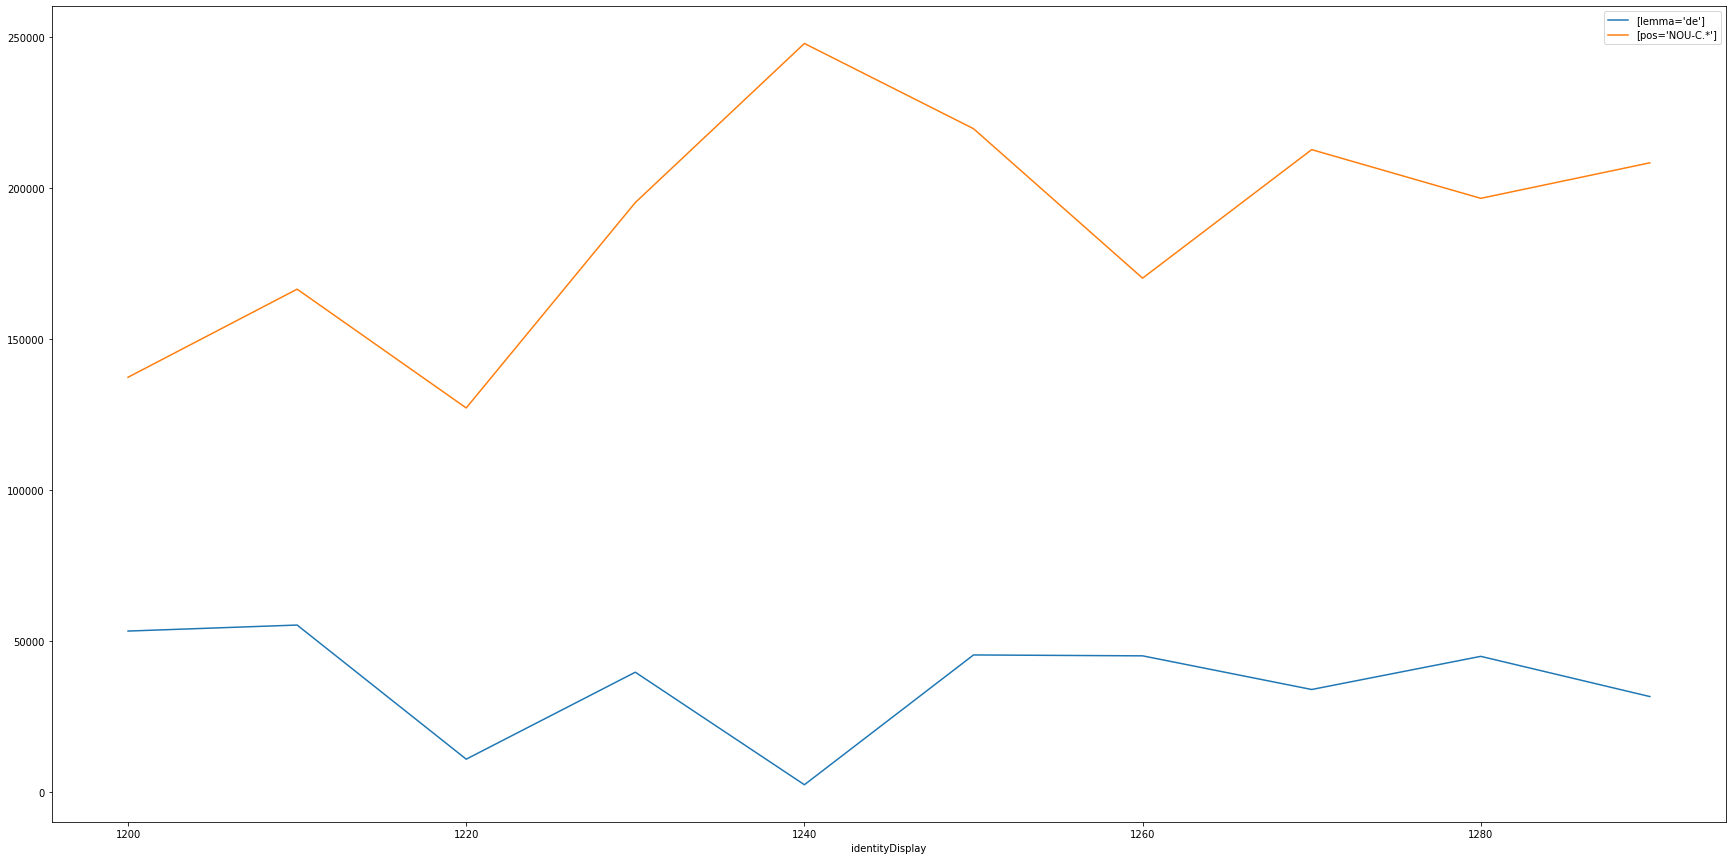

In [13]:
search_and_group_multiple('gysseling', ["[lemma='de']", "[pos='NOU-C.*']"], 'decade', values=[str(1200 + 10*j) for j in range(0,10)])
#silly_grouping('gysseling', "[lemma='de']",'decade', [str(1200 + 10*j) for j in range(0,10)])

...Searching gysseling at result 0...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

,identity,identityDisplay,size,docs,subcorpus_docs,subcorpus_tokens,hits_per_million
0,str:1201,1201,90,1,1,1628,55282.555283
0,str:1210,1210,47,1,1,4318,10884.668828
0,str:1220,1220,140,1,1,3885,36036.036036
0,str:1236,1236,170,1,1,4210,40380.047506
0,str:1237,1237,196,1,1,4463,43916.647995
0,str:1240,1240,111,4,4,19526,5684.728055
0,str:1248,1248,652,1,1,13394,48678.512767
0,str:1249,1249,12,1,1,273,43956.043956
0,str:1251,1251,66,2,5,1154,57192.374350
0,str:1252,1252,9,1,1,77,116883.116883


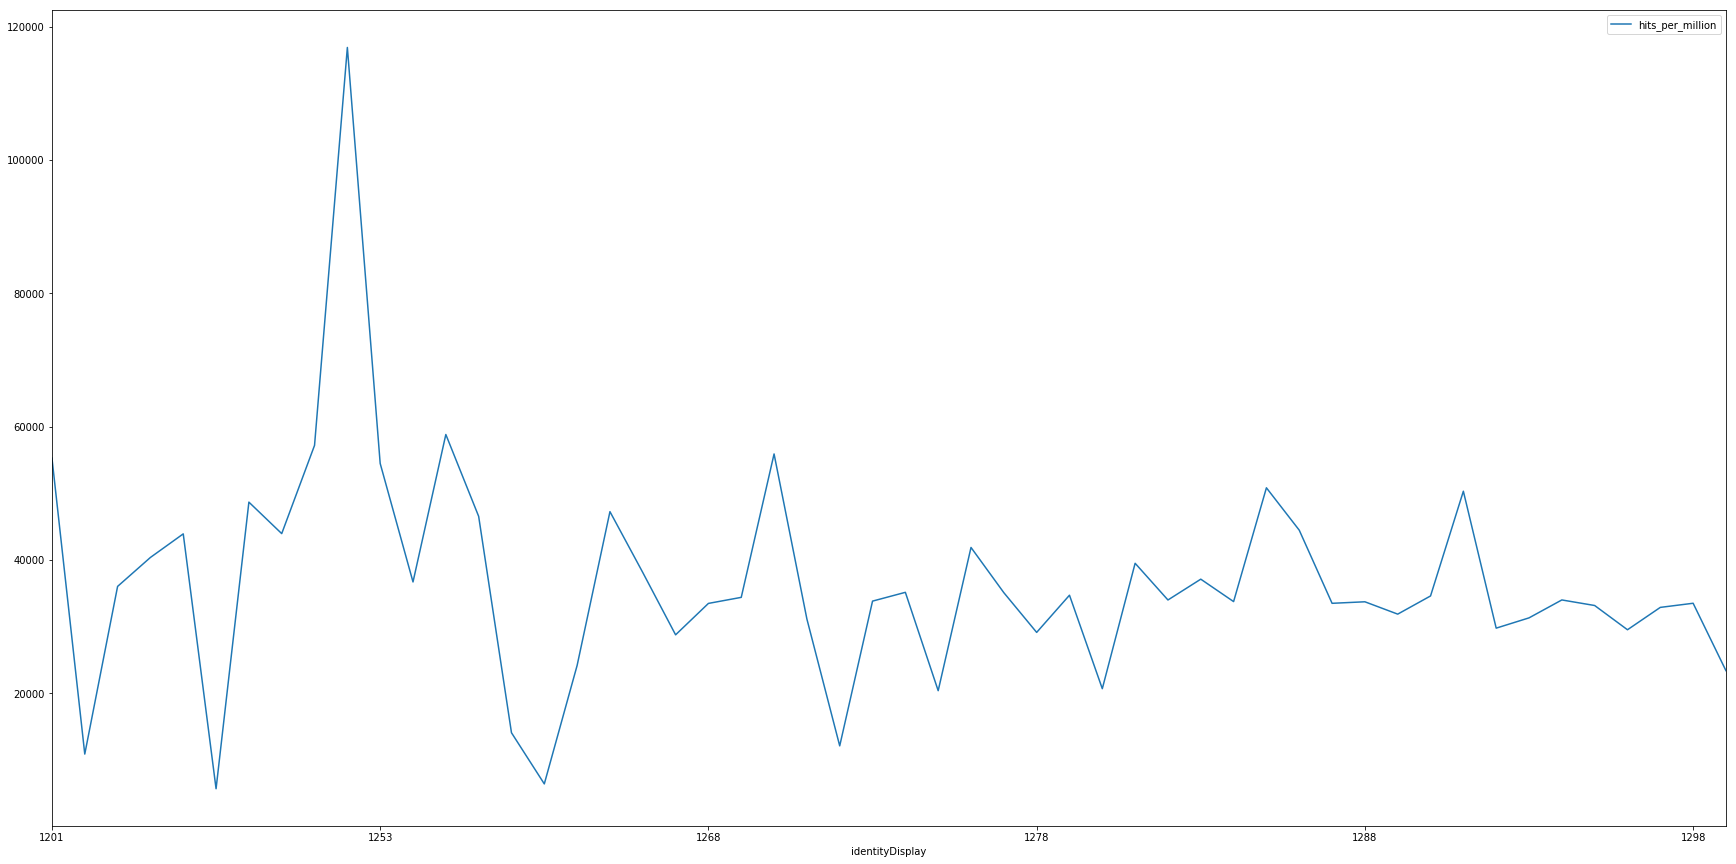

In [9]:
silly_grouping('gysseling', "[lemma='de']",'witness_year_from', [str(1200 + j) for j in range(0,100)])

...Searching gysseling at result 0...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

,identity,identityDisplay,size,docs,subcorpus_docs,subcorpus_tokens,hits_per_million
0,str:1201,1201,31,1,1,1628,19041.769042
0,str:1220,1220,87,1,1,3885,22393.822394
0,str:1236,1236,133,1,1,4210,31591.448931
0,str:1237,1237,126,1,1,4463,28232.130854
0,str:1240,1240,83,4,4,19526,4250.742600
0,str:1248,1248,41,1,1,13394,3061.072122
0,str:1249,1249,7,1,1,273,25641.025641
0,str:1251,1251,14,3,5,1154,12131.715771
0,str:1253,1253,41,3,3,3304,12409.200969
0,str:1254,1254,71,1,1,3569,19893.527599


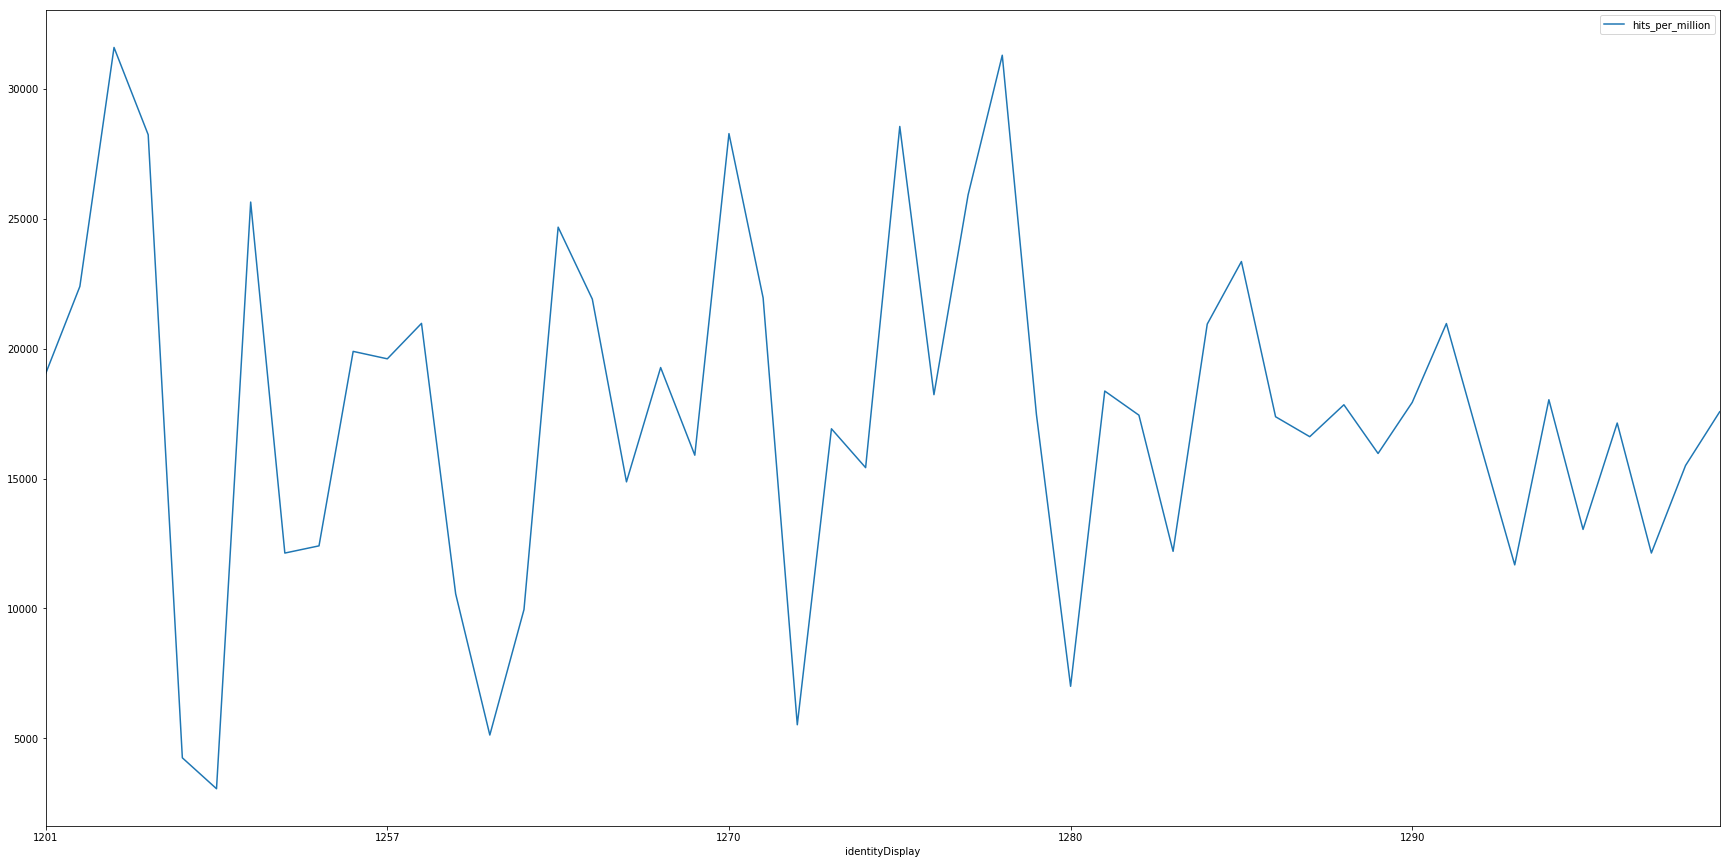

In [10]:
silly_grouping('gysseling', "[lemma='die']",'witness_year_from', [str(1200 + j) for j in range(0,100)])

In [3]:
silly_grouping('gysseling', '[pos="pd"&pos_type="dem"&pos_subtype="art"]','decade', [str(1200 + 10*j) for j in range(0,11)])

REQUEST URL:http://corpusgysseling.ivdnt.org/blacklab-server/Gysseling/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Bpos%3D%22pd%22%26pos_type%3D%22dem%22%26pos_subtype%3D%22art%22%20%7C%20lemma%3D%27gna_gna_187862%27%5D&filter=decade%3A%221200%22&group=field%3Adecade%3Ai
REQUEST URL:http://corpusgysseling.ivdnt.org/blacklab-server/Gysseling/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Bpos%3D%22pd%22%26pos_type%3D%22dem%22%26pos_subtype%3D%22art%22%20%7C%20lemma%3D%27gna_gna_549512%27%5D&filter=decade%3A%221210%22&group=field%3Adecade%3Ai
REQUEST URL:http://corpusgysseling.ivdnt.org/blacklab-server/Gysseling/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Bpos%3D%22pd%22%26pos_type%3D%22dem%22%26pos_subtype%3D%22art%22%20%7C%20lemma%3D%27gna_gna_140990%27%5D&filter=decade%3A%221220%22&group=field%3Adecade%3Ai
REQUEST URL:http://corpusgysseling.ivdnt.org/blacklab-server/Gysseling/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt

,identity,identityDisplay,size,docs,subcorpus_docs,subcorpus_tokens,hits_per_million
0,str:1200,1200,106,1,1,1595,66457.680251
0,str:1210,1210,94,1,1,1628,57739.557740
0,str:1220,1220,59,1,1,4318,13663.733210
0,str:1230,1230,864,3,4,12755,67738.141905
0,str:1240,1240,56,2,2,17329,3231.577125
0,str:1250,1250,1768,10,11,23599,74918.428747
0,str:1260,1260,8233,71,72,132986,61908.772352
0,str:1270,1270,4466,194,196,64773,68948.481620
0,str:1280,1280,42773,646,649,641148,66713.145795
0,str:1290,1290,38356,1162,1169,580508,66073.163505


In [14]:
miljoen=1000000
gysseling_tokens=1547893
gysseling_hits_article=102706
gysseling_hits_article_de=60211
gysseling_hits_article_die=13642
gysseling_hits_article_dat=13642
gysseling_de_per_million = (gysseling_hits_article_de / 1547893) * miljoen
print(gysseling_de_per_million)

38898.683565336876


In [5]:
test_ja_nl()

{'numberOfHits': 1725, 'numberOfDocs': 534, 'windowHasNext': 'true', 'subcorpusTokens': 14392455, 'subcorpusDocs': 2439}
Empty DataFrame
Columns: [identity, identityDisplay, size, docs, subcorpus_docs, subcorpus_tokens, hits_per_million]
Index: []
{'numberOfHits': 1725, 'numberOfDocs': 534, 'windowHasNext': 'true', 'subcorpusTokens': 14392455, 'subcorpusDocs': 2439}


REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn-intern/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27London%27%20%7C%20lemma%3D%27gna_gna_336334%27%5D&filter=pubYear_from%3A%221995%22&group=field%3ApubYear_from%3Ai
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn-intern/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27London%27%20%7C%20lemma%3D%27gna_gna_5413%27%5D&filter=pubYear_from%3A%221996%22&group=field%3ApubYear_from%3Ai
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn-intern/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27London%27%20%7C%20lemma%3D%27gna_gna_35491%27%5D&filter=pubYear_from%3A%221997%22&group=field%3ApubYear_from%3Ai
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn-intern/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27London%27%20%7C%20lemma%3D%27gna_gna_456587%27%5D&filter=pubYear_from%3A%221998%22&group=field%3ApubYear_

,identity_x,identityDisplay,size_x,docs_x,subcorpus_docs_x,subcorpus_tokens_x,[lemma='London'],identity_y,size_y,docs_y,subcorpus_docs_y,subcorpus_tokens_y,[lemma='Londen']
0,str:1995,1995,106,26,129702,68902629,1.538403,str:1995,1963,369,129702,68902629,28.489479
1,str:1996,1996,116,77,5926,17066725,6.796852,str:1996,2206,298,5926,17066725,129.257371
2,str:1997,1997,43,29,11482,9156865,4.695930,str:1997,814,331,11482,9156865,88.895053
3,str:1998,1998,3,2,2625,3426533,0.875521,str:1998,83,48,2625,3426533,24.222735
4,str:1999,1999,193,113,209630,86376131,2.234414,str:1999,2688,1971,209630,86376131,31.119708
5,str:2000,2000,272,199,270510,113077273,2.405435,str:2000,3526,2402,270510,113077273,31.182216
6,str:2001,2001,188,152,239456,104084792,1.806220,str:2001,2710,1897,239456,104084792,26.036465
7,str:2002,2002,154,123,223272,94053709,1.637362,str:2002,2249,1603,223272,94053709,23.911869
8,str:2003,2003,136,97,197359,78966751,1.722244,str:2003,2160,1580,197359,78966751,27.353284
9,str:2004,2004,175,112,209616,77836861,2.248292,str:2004,2157,1554,209616,77836861,27.711806


,identity_x,identityDisplay,size_x,docs_x,subcorpus_docs_x,subcorpus_tokens_x,[lemma='London'],identity_y,size_y,docs_y,subcorpus_docs_y,subcorpus_tokens_y,[lemma='Londen']
0,str:1995,1995,106,26,129702,68902629,1.538403,str:1995,1963,369,129702,68902629,28.489479
1,str:1996,1996,116,77,5926,17066725,6.796852,str:1996,2206,298,5926,17066725,129.257371
2,str:1997,1997,43,29,11482,9156865,4.695930,str:1997,814,331,11482,9156865,88.895053
3,str:1998,1998,3,2,2625,3426533,0.875521,str:1998,83,48,2625,3426533,24.222735
4,str:1999,1999,193,113,209630,86376131,2.234414,str:1999,2688,1971,209630,86376131,31.119708
5,str:2000,2000,272,199,270510,113077273,2.405435,str:2000,3526,2402,270510,113077273,31.182216
6,str:2001,2001,188,152,239456,104084792,1.806220,str:2001,2710,1897,239456,104084792,26.036465
7,str:2002,2002,154,123,223272,94053709,1.637362,str:2002,2249,1603,223272,94053709,23.911869
8,str:2003,2003,136,97,197359,78966751,1.722244,str:2003,2160,1580,197359,78966751,27.353284
9,str:2004,2004,175,112,209616,77836861,2.248292,str:2004,2157,1554,209616,77836861,27.711806


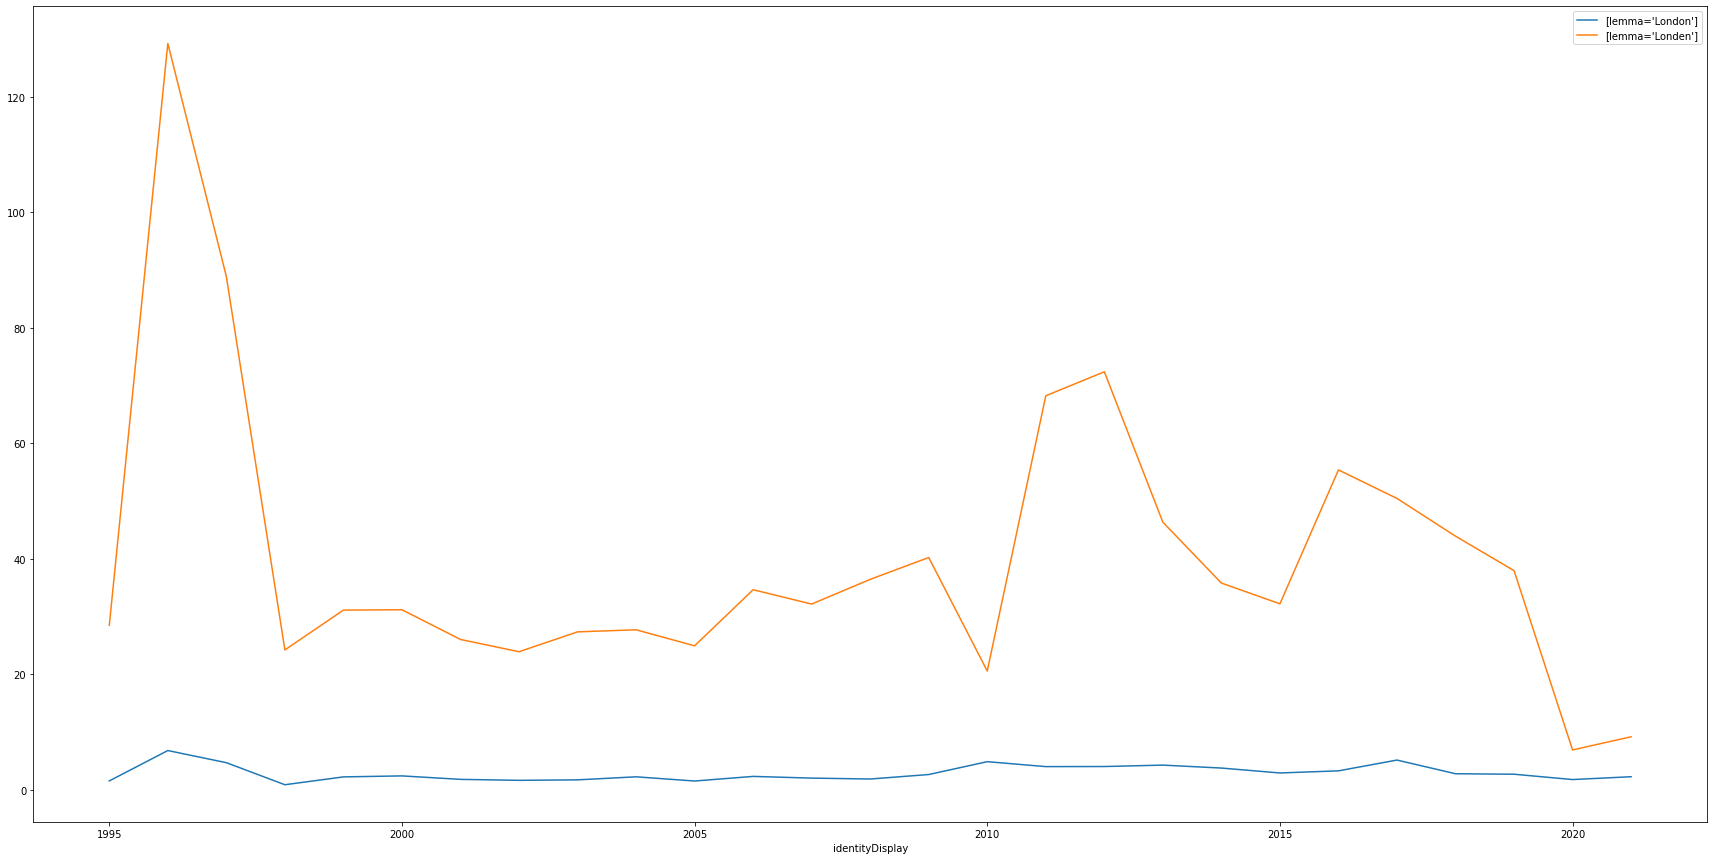

In [7]:

values = [str(j) for j in range(1995,2022)]
#silly_grouping('chn_i', "[lemma='de']",'pubYear_from', values)
search_and_group_multiple('chn_i', ["[lemma='London']", "[lemma='Londen']"], 'pubYear_from', values=values)


In [ ]:
df_geo = pd.read_csv('endoniem.csv',sep='\t')
#display_df(df_geo)

def lookup(x):
    return frequency_info('chn_i',wordQuery(x))

# rf = 1000000 * (summary['numberOfHits'] / info['tokenCount'])
def lookup_names(row):
    print("nl=" + str(row['nl']))
    f_nl = frequency_info('chn_i', wordQuery(row['nl']))

    print(str(f_nl))

    f_endo = frequency_info('chn_i',  wordQuery(row['endoniem']))

    print(str(f_endo))
    return [row['nl'], row['endoniem'], f_nl['hits_per_million'], f_nl['numberOfHits'],
            f_endo['hits_per_million'], f_endo['numberOfHits']]

dinges = df_geo.apply(lambda r: lookup_names(r), axis=1, result_type='expand')
display_df(dinges)
# print(dinges)
for ind in df_geo.index:
     break
     nl = df_geo['nl'][ind]
     endo = df_geo['endoniem'][ind]
     fnl = relative_frequency('chn_i', wordQuery(nl))
     fendo = relative_frequency('chn_i', wordQuery(endo))
     print(nl, fnl, endo, fendo)

nl=Koraalzee
[word="Koraalzee"]
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn-intern/hits?&number=10&maxcount=-1&waitfortotal=yes&first=0&patt=%5Bword%3D%22Koraalzee%22%5D&filter=
{'windowHasNext': 'true', 'numberOfHits': 43, 'numberOfDocs': 34, 'hits_per_million': 0.0224513328996338}
[word="Coral"] [word="Sea"]
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn-intern/hits?&number=10&maxcount=-1&waitfortotal=yes&first=0&patt=%5Bword%3D%22Coral%22%5D%20%5Bword%3D%22Sea%22%5D&filter=
{'windowHasNext': 'true', 'numberOfHits': 93, 'numberOfDocs': 48, 'hits_per_million': 0.048557533945719614}
nl=Andes
[word="Andes"]
REQUEST URL:http://svotmc10.ivdnt.loc/blacklab-server/chn-intern/hits?&number=10&maxcount=-1&waitfortotal=yes&first=0&patt=%5Bword%3D%22Andes%22%5D&filter=
{'windowHasNext': 'true', 'numberOfHits': 2169, 'numberOfDocs': 1529, 'hits_per_million': 1.1324870013792026}
[word="Cordillera"] [word="de"] [word="los"] [word="Andes"]
REQUEST URL:http://svotmc10.ivdnt.l

In [2]:
opensonar_lemma_query("fiets")

REQUEST URL:http://pcob67:8080/blacklab-server/Wablieft/hits?&number=1000&maxcount=-1&waitfortotal=yes&first=0&patt=%5Blemma%3D%27fiets%5D&filter=
<?xml version="1.0" encoding="utf-8" ?><error><code>PATT_SYNTAX_ERROR</code><message>Syntax error in CorpusQL pattern: Error parsing query: Lexical error at line 1, column 15.  Encountered: &lt;EOF&gt; after : &quot;\&apos;fiets]&quot;</message></error>
                                                                 

ValueError: An error occured when searching corpus wablieft: 'NoneType' object has no attribute 'find'